In [14]:
import numpy as np
from sklearn import datasets
from sklearn import __version__ as sklearn_version
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import tree
import pydotplus as pdp
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import copy
%matplotlib inline

## 関数 dt_
- input : 
     - X : 入力データ
     - y : 出力データ
     - restrict : 制約（葉の数か深さか）
     - num : 葉数 or 深さ
     - random : シード
- output : 
    - dt : 決定木
    - X.columns : 入力データの特徴量（使用した特徴量ではない）


In [15]:
def dt_(X, y, restrict, num, random):
    
    if restrict == "depth":
        dt = DecisionTreeClassifier(max_depth = num, random_state=random)
    elif restrict == "leaf":
        dt = DecisionTreeClassifier(max_leaf_nodes = num, random_state=random)
    else:
        print("please input restrict tree by depth or leaf")
    
    dt.fit(X, y)
    
    #f_list = list(set(dt.tree_.feature))  #DT.tree_.feature : 決定木の分割に使われた変数を取得
    #f_list.remove(-2)
            
    return [dt, X.columns]

## 関数 enu
- input : 
    - X : 入力
    - y : 出力
    - restrict : 制約（葉の数か深さか）
    - num : 葉数 or 深さ
    - random : シード
- output : 
    - rashomon set : list[gain importance, permutation importance]

In [16]:
def enu(X, y, restrict, num, random, model_num):
    
    # dt_X : モデルと入力データの特徴量の組を格納するリスト
    # f_list : 計算済みの入力データの特徴量を格納するリスト
    # rashomon : 羅生門集合に属するモデル，予測精度，gain importance, permutation importance を格納するリスト
    dt_X, f_list = [], []
    rashomon = []
    score_list = []

    n = len(list(X.columns.values))
    column = list(range(n))
    X.columns = column # 暫定的に特徴量を[0, 1, ..., n-1] に置き換える
    
    # ベースライン決定木の作成
    base = dt_(X, y, restrict, num, random)
    dt_X.append(base)
    
    #print(X.head())
    f_list.append(list(X.columns.values))
    f_list.append([]) # 空集合を格納
    score = 1 - base[0].score(X, y)
    score_list.append(score)
    gain, per = get_fi(X, y, base[0], n)
    rashomon.append([gain, per])
    
    count = 1
    
    # dt_X が空になるまで実行
    while len(dt_X) != 0:
        dt_pop = dt_X.pop(0) # モデルと入力データの特徴量をポップ
        dt = dt_pop[0]
        X_use = list(dt_pop[1])
        feature = list(set(dt.tree_.feature))  #dt.tree_.feature : 決定木の分割に使われた変数を取得
        feature.remove(-2) # 葉ノード（-2）を削除
        
        #print("next " + str(feature) )

        for i in range(len(feature)):
            new_X = copy.copy(X_use) # 入力データの特徴量をコピー
            new_X.remove(X_use[feature[i]])
            
            if new_X in f_list: continue # 既に計算してたら計算しない
            
            f_list.append(new_X)
            new = dt_(X[new_X], y, restrict, num, random)
            score = 1 - new[0].score(X[new_X], y)
            
            if count < model_num:
                score_list.append(score)
                gain, per = get_fi(X[new_X], y, new[0], n)
                rashomon.append([gain, per])
            elif score < max(score_list):
                point = score_list.index(max(score_list))
                gain, per = get_fi(X[new_X], y, new[0], n)
                rashomon[point] = [gain, per]
                score_list[point] = score
            #print(new_X)
            #print(list(set(new[0].tree_.feature)) )
            dt_X.append(new)
            count += 1
            
    return rashomon, score_list

## 関数 get_fi
- input : 
    - X : input
    - y : label
    - model : predict model
    - n : 元データの特徴量の数
- output : 
    - gain importance
    - permutation importance

In [17]:
def get_fi(X, y, model, n):
    
    gain = [0.0]*n
    per = [0.0]*n
    
    # gain ベースの特徴量重要度を計算
    gain_fi = model.feature_importances_
    # permutation importance ベースの特徴量重要度を計算
    result = permutation_importance(model, X, y, n_repeats=5, random_state=0)
    per_fi = result.importances_mean/sum(result.importances_mean)
    
    feature = list(X.columns.values)
    for i in range(len(feature)):
        gain[feature[i]] = gain_fi[i]
        per[feature[i]] = per_fi[i]
        
    #print(gain)
    
    return gain, per    

## 関数 VIC_scatter
- input : 
    - VIC : VIC list 

In [18]:
def VIC_scatter(VIC, imp, feature_name):
    
    fi_list = []
    label = []
    
    for i in range(len(VIC[0])):
        fi = []
        for j in range(len(VIC)):
            fi.append(VIC[j][i])
        fi_list.append(fi)
        label.append("X{}".format(i))
        
    if len(feature_name) != 0: label = feature_name
     
    # 箱ひげ図
    fig, ax = plt.subplots(figsize=(20, 10))
    bp = ax.boxplot(fi_list)
    ax.set_xticklabels(label)
    # タイトル名
    plt.title("box plot of {} importance for adlut dataset by lawler".format(imp))
    # ラベル名
    plt.xlabel("feature")
    plt.ylabel("feature importance")
    
    # 散布図行列
    df = pd.DataFrame(VIC, columns=label)

    g = sns.catplot(data=df, kind='swarm', height=10, aspect=2)
    g.set(ylim=(0.0, 0.4))
    g.fig.suptitle("swarm plot of {} importance for adult dataset by lawler".format(imp),
                      y=0.95, size=24)

## 関数 VIC_correlation
- input : 
    - VIC : VIC list 

In [19]:
def VIC_correlation(VIC, imp, feature_name):
    
    fi_list = []
    label = []
    
    for i in range(len(VIC[0])):
        fi = []
        for j in range(len(VIC)):
            fi.append(VIC[j][i])
        fi_list.append(fi)
        label.append("X{}".format(i))
        
    if len(feature_name) != 0: label = feature_name
    
    # 散布図行列
    df = pd.DataFrame(VIC, columns=label)
    
    corr = df.corr()
    plt.figure(figsize=(20, 10)) 
    sns.heatmap(corr, square=True, annot=True, cmap='hot')
    plt.title("heat map of correlation coefficients of {} importance for adult dataset by lawler".format(imp))
    
    g = sns.pairplot(df)
    g = g.map_upper(plt.scatter)
    g = g.map_lower(sns.kdeplot, cmap='hot', shade=True)
    g = g.map_diag(plt.hist)
    plt.subplots_adjust(top=0.9)
    g = g.fig.suptitle("pair plot of {} importance for adult dataset by lawler".format(imp),
                      y=0.95, size=30)

## Experiment for adult

In [20]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('data/adult/pre_adult3.csv', index_col=0)
data.head()

,age,education_num,marital_status,race,sex,capital_gain,capital_loss,hours_per_work,label,occupation_blueCollar,occupation_other,occupation_professional,occupation_sales,occupation_whiteCollar
0,39,13,0,1,1,2174,0,40,0,0,1,0,0,0
1,50,13,1,1,1,0,0,13,0,0,0,0,0,1
2,38,9,1,1,1,0,0,40,0,1,0,0,0,0
3,53,7,1,0,1,0,0,40,0,1,0,0,0,0
4,28,13,1,0,0,0,0,40,0,0,0,1,0,0


In [8]:
X = data.drop("label", axis=1)
print(X.head())
print("-" * 50)
y = data["label"]
print(y.head())

   age  education_num  marital_status  race  sex  capital_gain  capital_loss  \
0   39             13               0     1    1          2174             0   
1   50             13               1     1    1             0             0   
2   38              9               1     1    1             0             0   
3   53              7               1     0    1             0             0   
4   28             13               1     0    0             0             0   

   hours_per_work  occupation_blueCollar  occupation_other  \
0              40                      0                 1   
1              13                      0                 0   
2              40                      1                 0   
3              40                      1                 0   
4              40                      0                 0   

   occupation_professional  occupation_sales  occupation_whiteCollar  
0                        0                 0                       0  
1   

In [9]:
base_dt = DecisionTreeClassifier(max_depth=12, random_state=0)
base_dt.fit(X, y)
base_score = 1 - base_dt.score(X, y)
print("base_score : " + str(base_score))

base_score : 0.13909159258767856


In [10]:
import time
start = time.time()

rashomon, score_list = enu(X, y, "depth", 12, 0, 100)

t = time.time() - start
print(t)

429.8509180545807


In [11]:
print(len(rashomon))
print(rashomon[0])
print(rashomon[0][1])

100
[[0.06411048239984446, 0.2174106971727494, 0.16667939556823766, 0.002363330041358705, 0.05080898549100032, 0.3180540463067675, 0.0949808690652568, 0.04887002680763625, 0.017508400291203218, 0.00475342703157586, 0.00415229683623214, 0.0020318408368434925, 0.008276202151294397], [0.10933838462740189, 0.1785463208873613, 0.12744102483986883, 0.002441024839868823, 0.08789642243399459, 0.23207311357600374, 0.08340493672863619, 0.07942118418997027, 0.04350882674582091, 0.015388220590532731, 0.018629901577878468, 0.0035346039681300625, 0.018376034994532123]]
[0.10933838462740189, 0.1785463208873613, 0.12744102483986883, 0.002441024839868823, 0.08789642243399459, 0.23207311357600374, 0.08340493672863619, 0.07942118418997027, 0.04350882674582091, 0.015388220590532731, 0.018629901577878468, 0.0035346039681300625, 0.018376034994532123]


In [13]:
print(max(score_list))
la = sorted(score_list)
print(la[:3])


0.1447083278050506
[0.13909159258767856, 0.13922427137234095, 0.13935695015700322]


(0.138, 0.176)

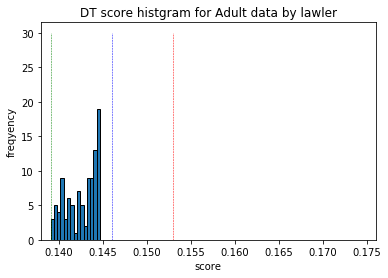

In [22]:
base_score = score_list[0]
hist, bin_edges = np.histogram(score_list, bins=20)
plt.title('DT score histgram for Adult data by lawler')
plt.xlabel('score')
plt.ylabel('freqyency')
plt.hist(score_list, bins=15, histtype='barstacked', ec='black')
# ε=1 に緑線
plt.vlines(base_score*1, 0, 30, "green", linestyle='dashed', linewidth=0.5)
# ε=1.05 に青い線
plt.vlines(base_score*1.05, 0, 30, "blue", linestyle='dashed', linewidth=0.5)
# ε=1.1 に赤い線
plt.vlines(base_score*1.1, 0, 30, "red", linestyle='dashed', linewidth=0.5)
plt.xlim(0.138, 0.176)

In [13]:
gain = []
per = []

for i in range(len(rashomon)):
    gain.append(rashomon[i][0])
    per.append(rashomon[i][1])

feature_name = list(data.columns)
print(feature_name)
feature_name.remove("label")
print(feature_name)

['age', 'education_num', 'marital_status', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_work', 'label', 'occupation_blueCollar', 'occupation_other', 'occupation_professional', 'occupation_sales', 'occupation_whiteCollar']
['age', 'education_num', 'marital_status', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_work', 'occupation_blueCollar', 'occupation_other', 'occupation_professional', 'occupation_sales', 'occupation_whiteCollar']


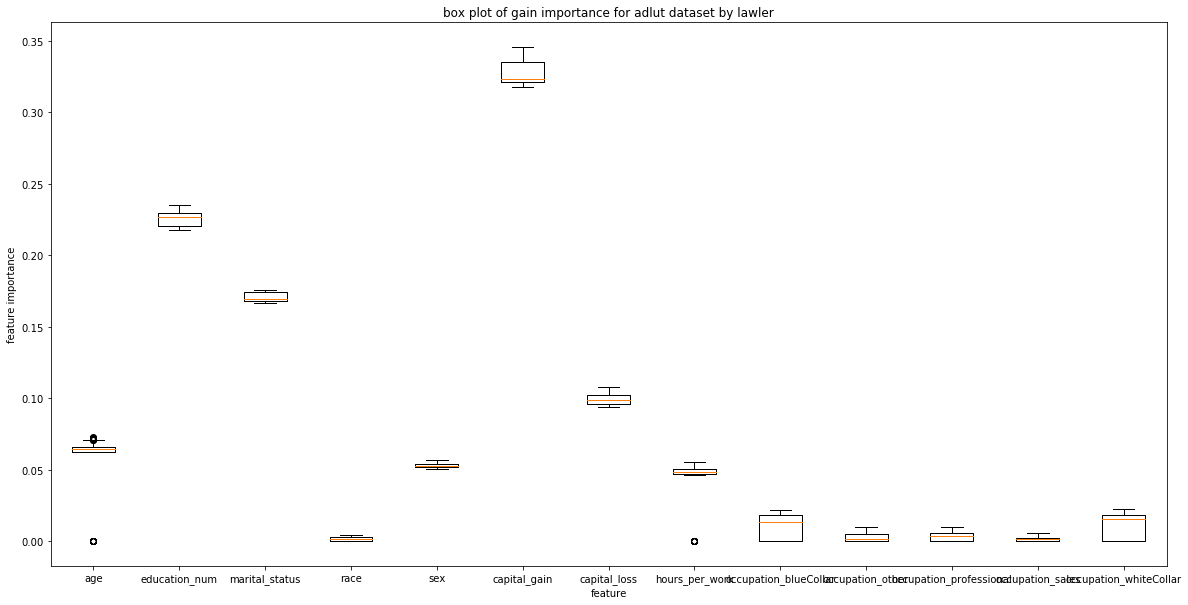

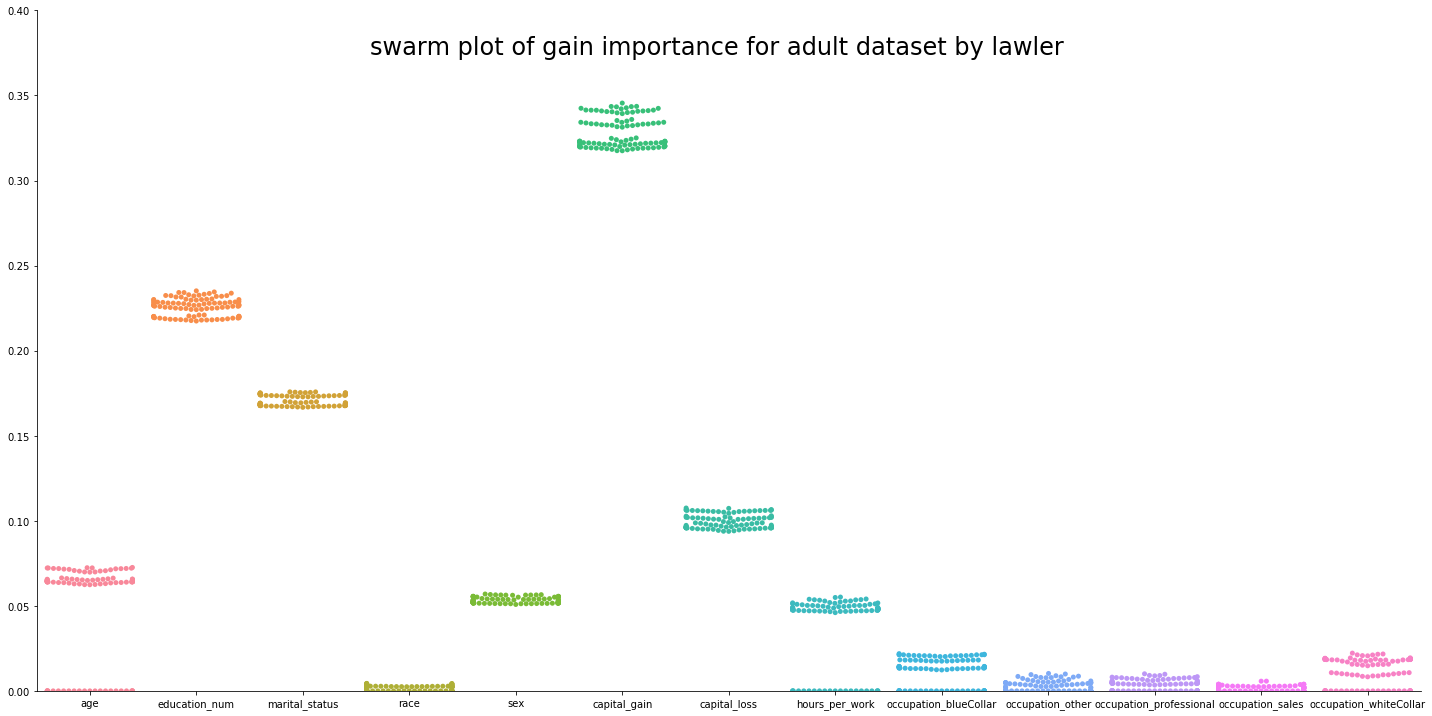

In [14]:
VIC_scatter(gain, "gain", feature_name)

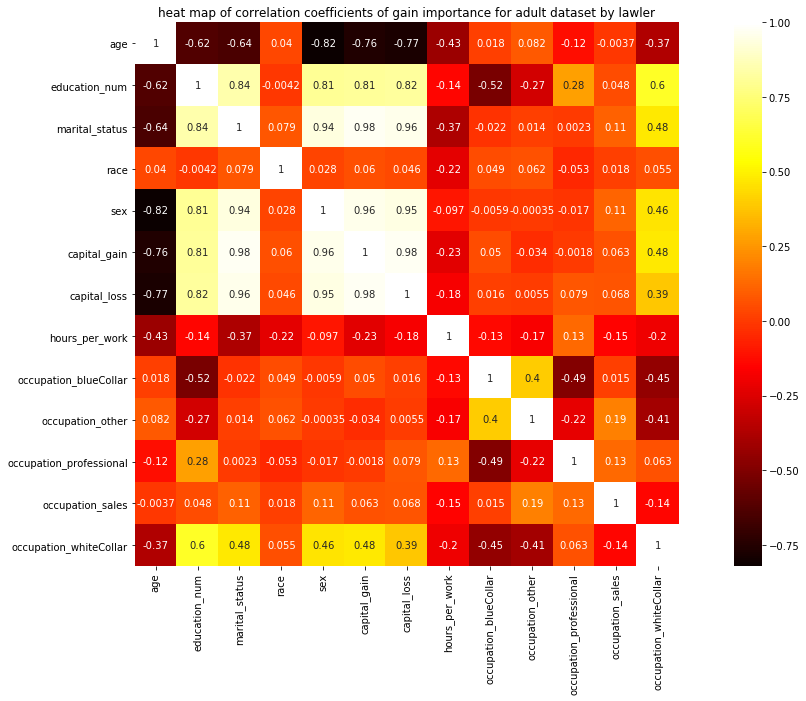

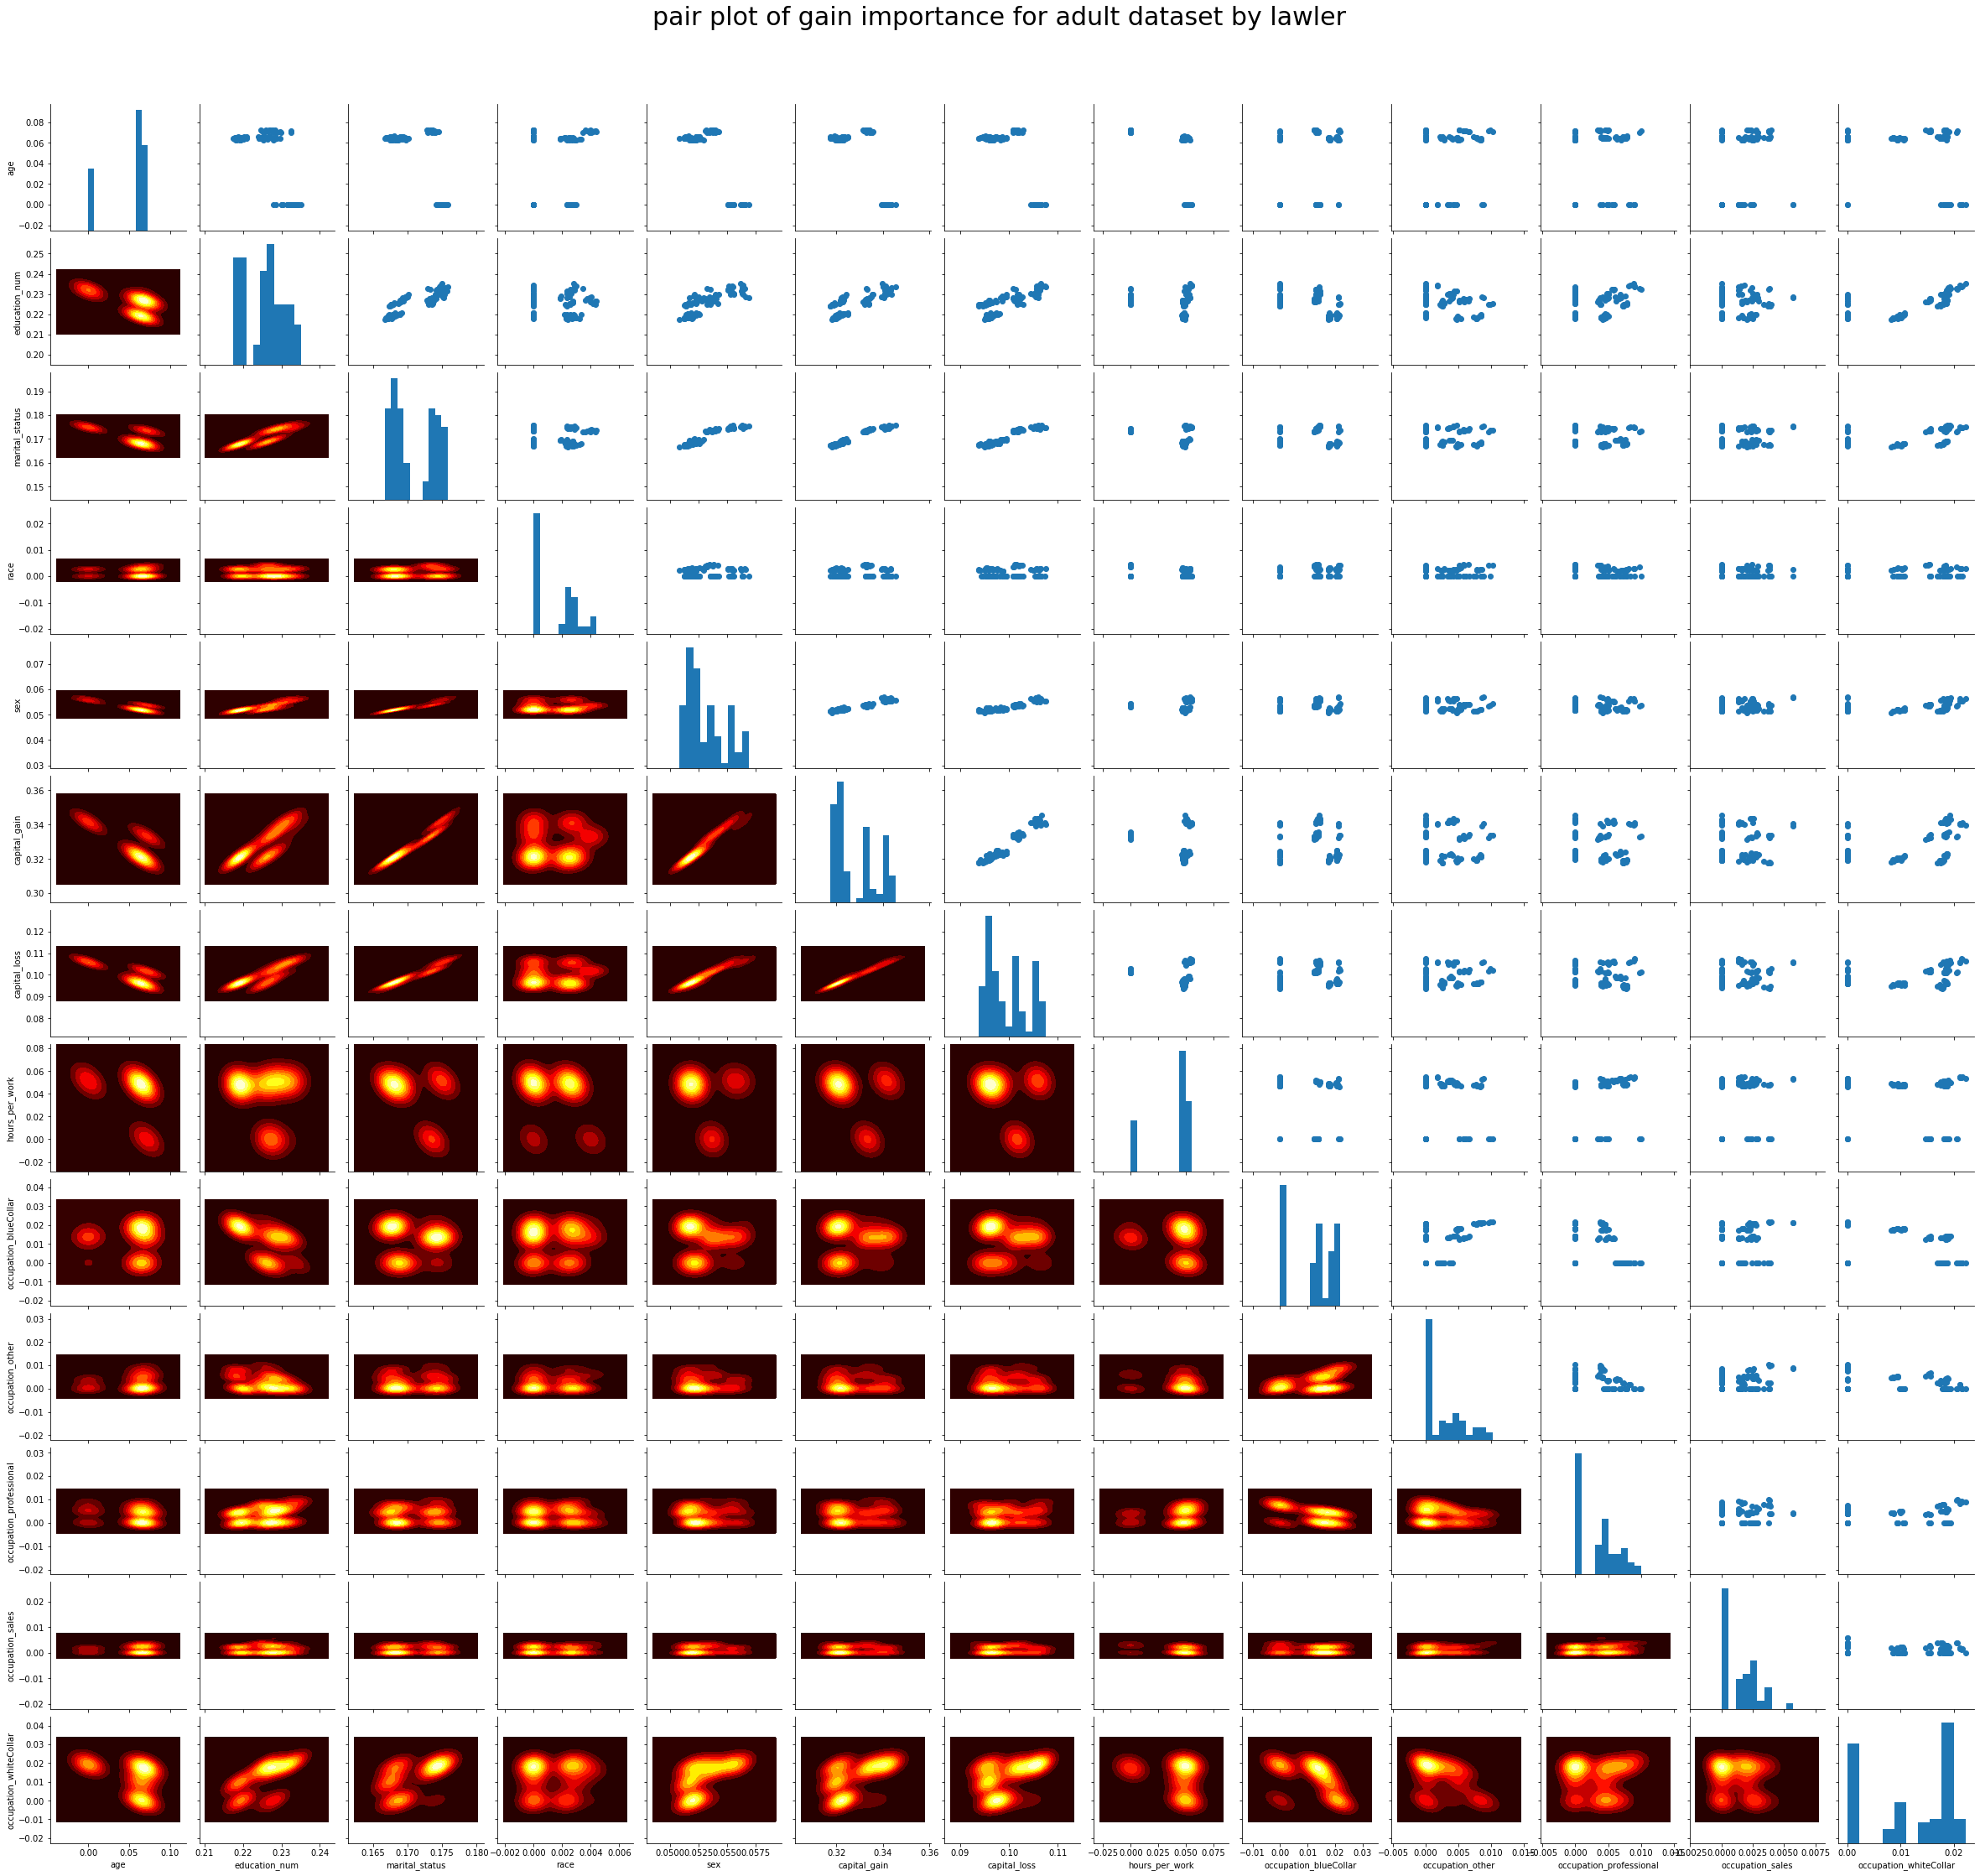

In [15]:
VIC_correlation(gain, "gain", feature_name)

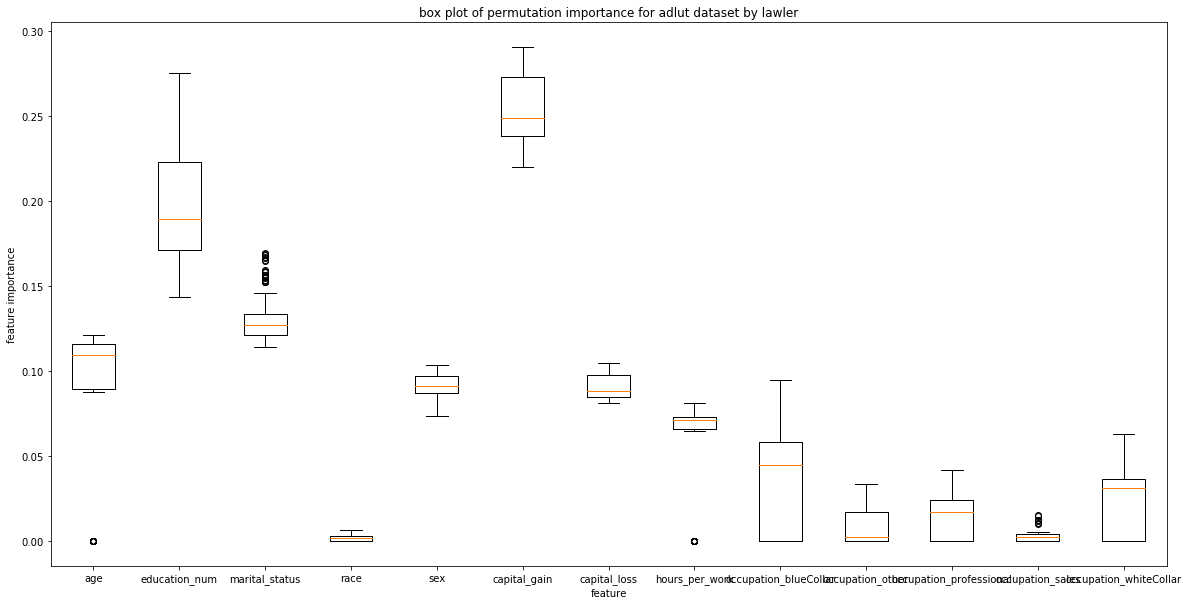

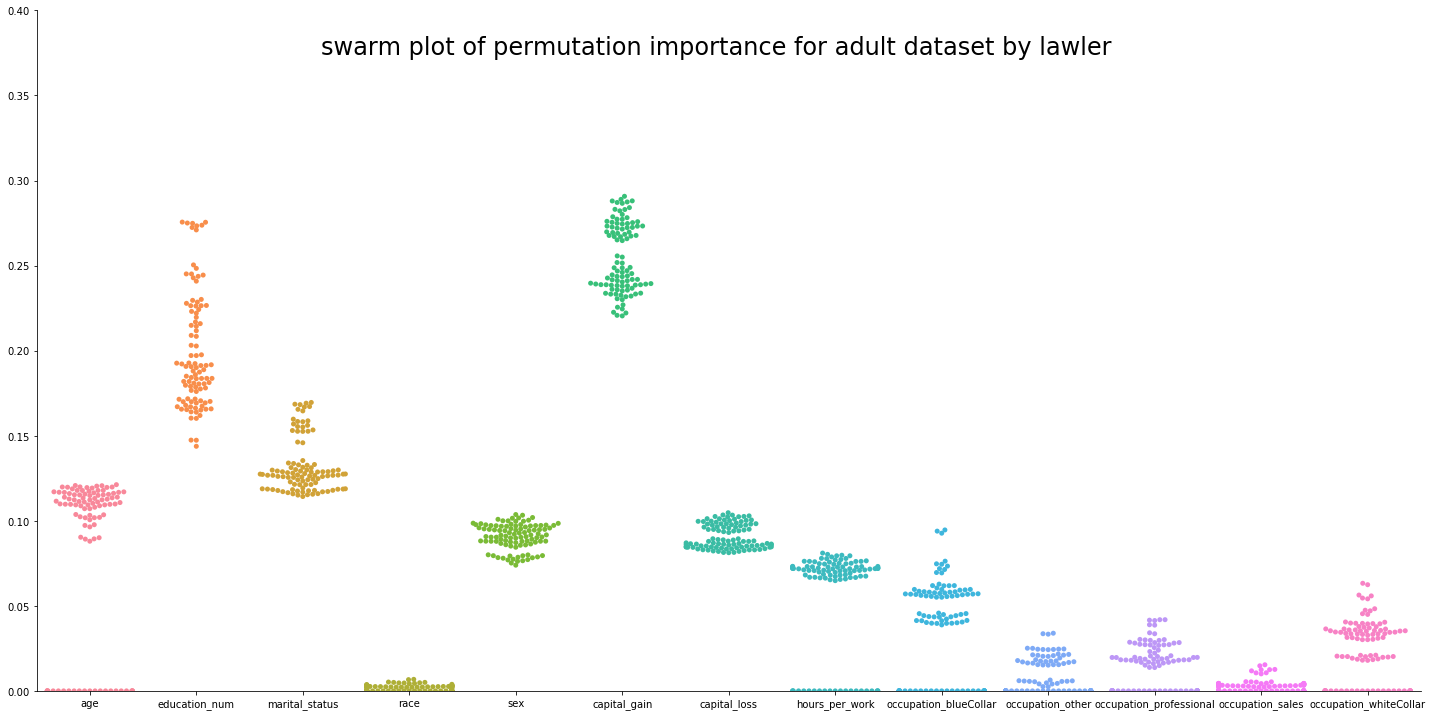

In [16]:
VIC_scatter(per, "permutation", feature_name)

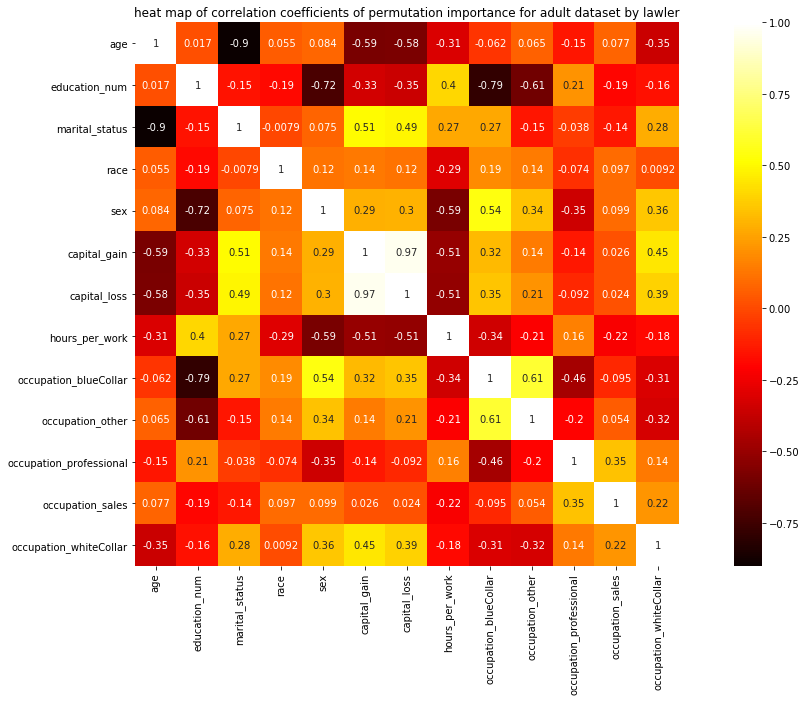

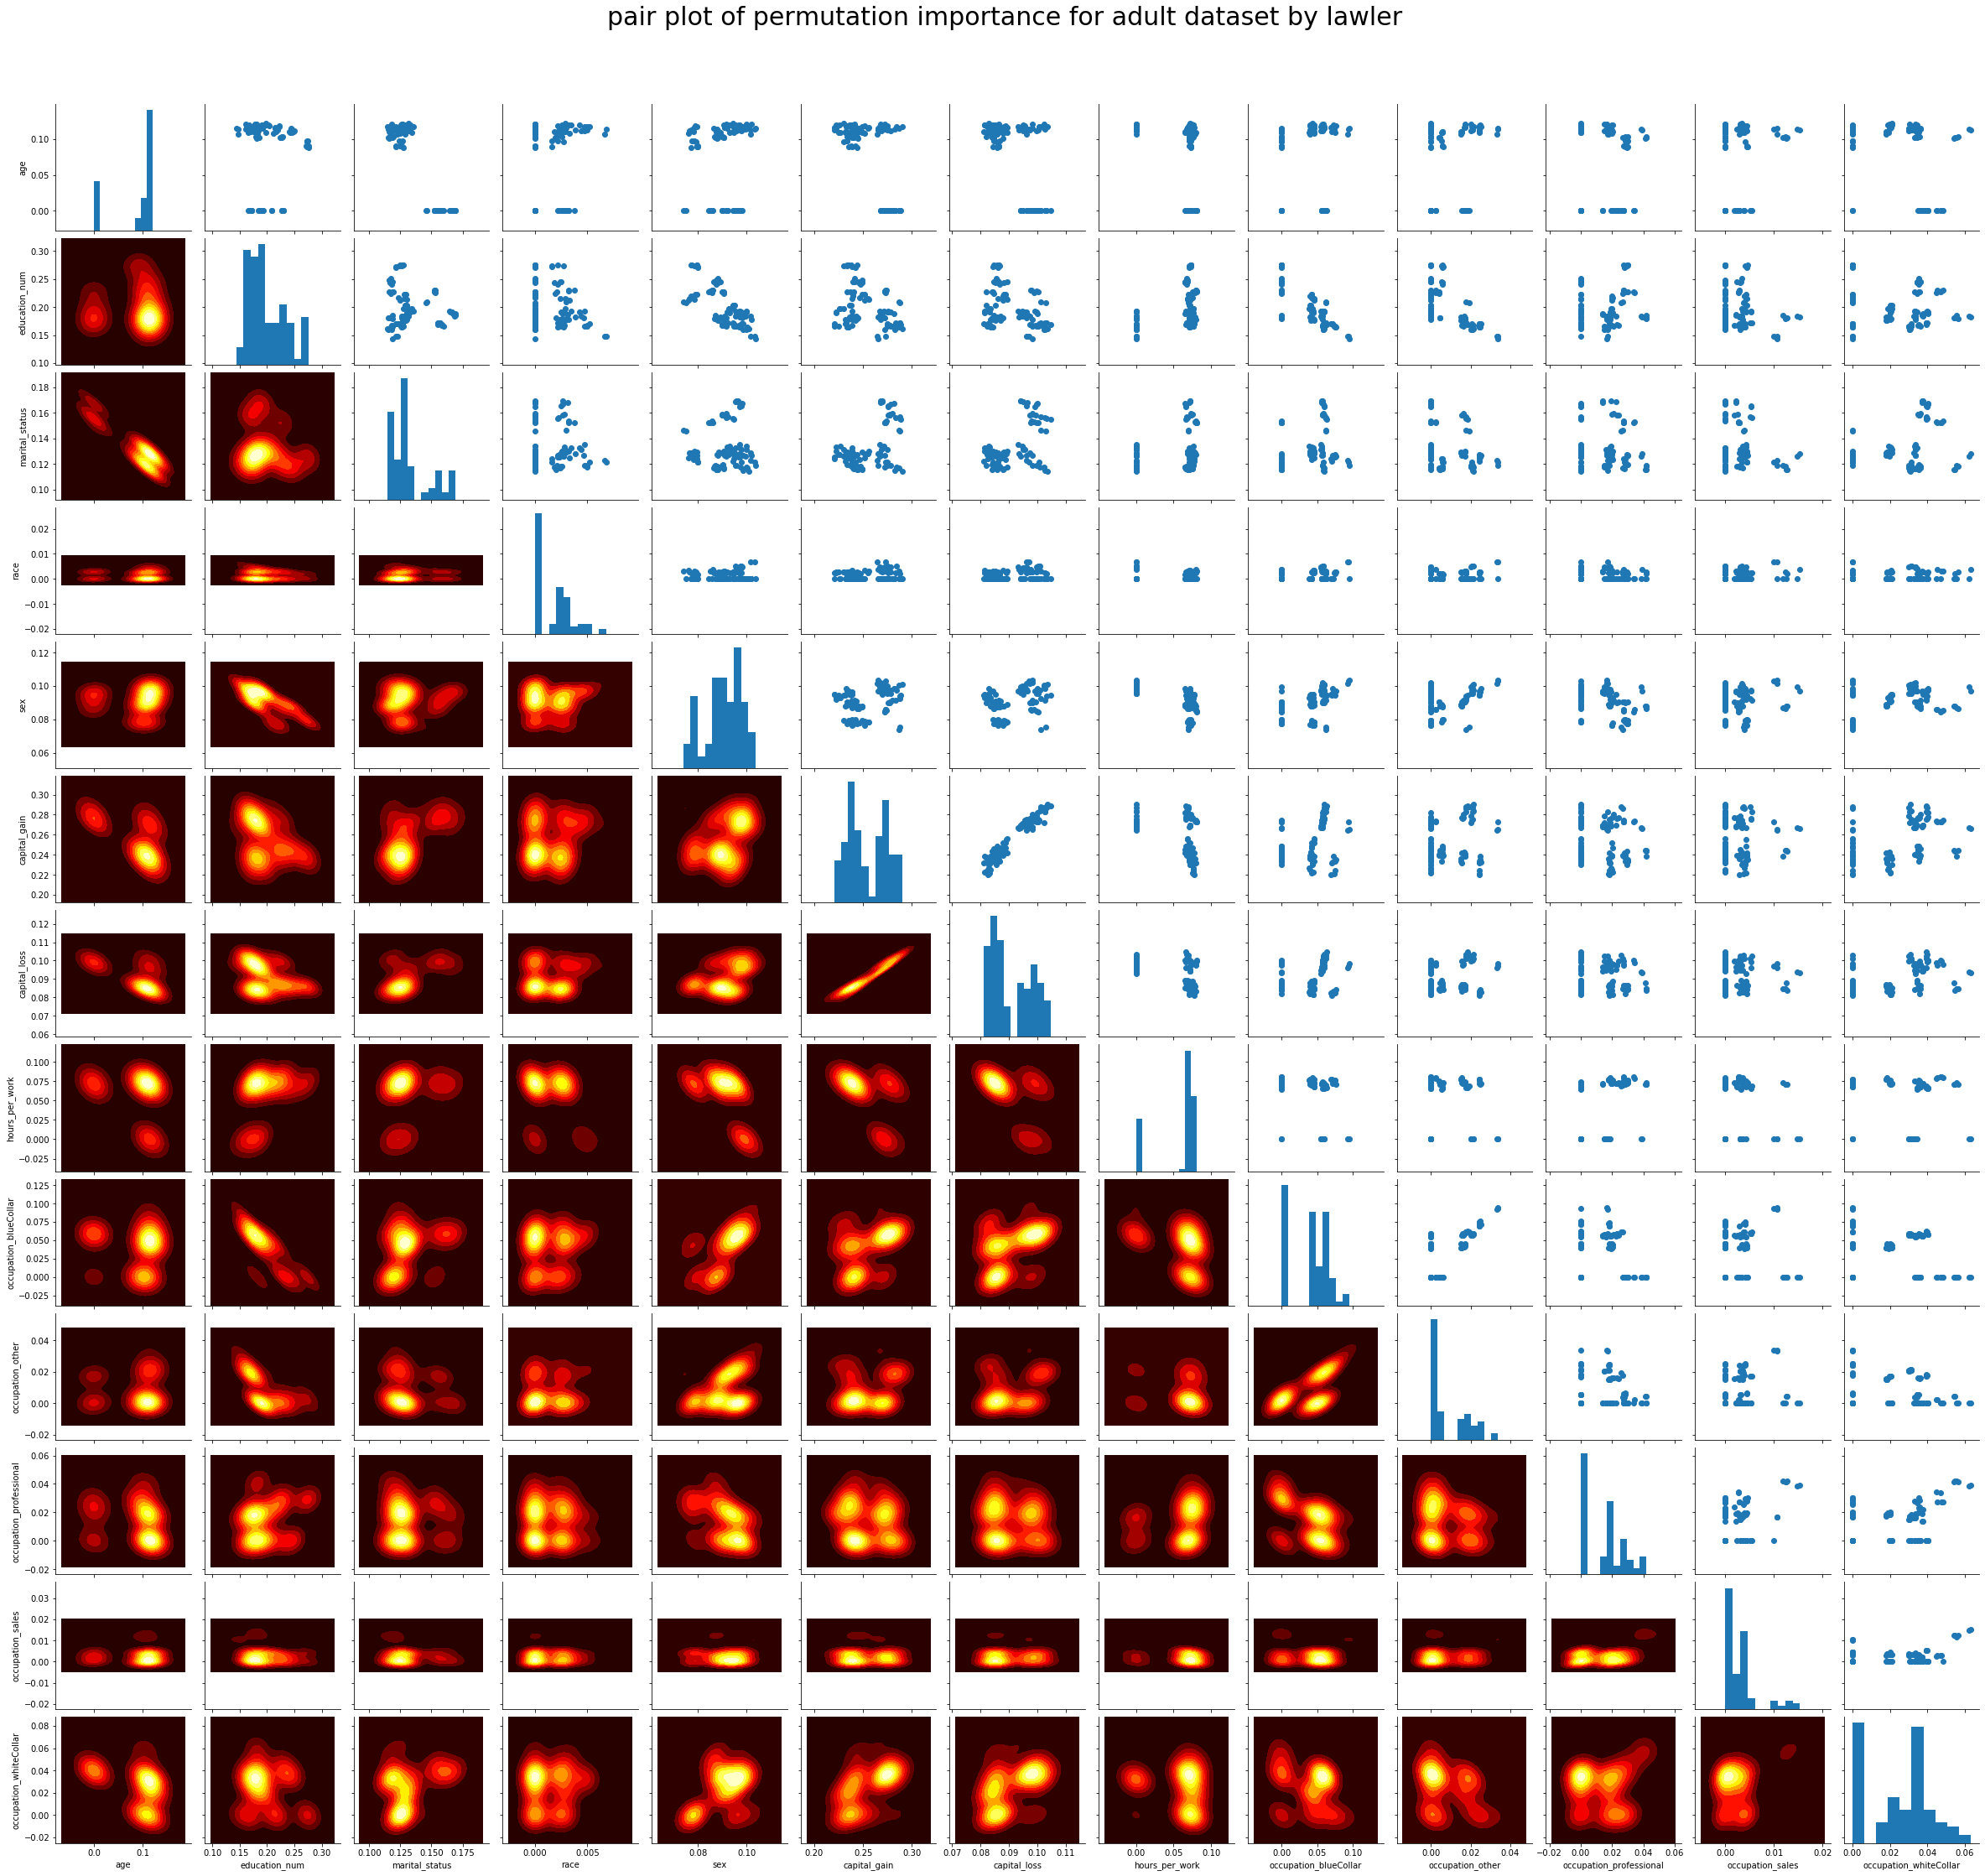

In [17]:
VIC_correlation(per, "permutation", feature_name)

In [25]:
df = pd.DataFrame(gain)
df = df[[0, 1, 2, 4, 5 , 6]]
feature = data.columns
print(feature[[0, 1, 2, 4, 5 , 6]])
df.columns = feature[[0, 1, 2, 4, 5 , 6]]
df.head()

Index(['age', 'education_num', 'marital_status', 'sex', 'capital_gain',
       'capital_loss'],
      dtype='object')


,age,education_num,marital_status,sex,capital_gain,capital_loss
0,0.064110,0.217411,0.166679,0.050809,0.318054,0.094981
1,0.000000,0.230028,0.174377,0.055651,0.341350,0.104924
2,0.000000,0.234146,0.174811,0.055159,0.341097,0.107295
3,0.065305,0.220402,0.168176,0.051574,0.322681,0.098132
4,0.064702,0.218348,0.166875,0.051418,0.318505,0.095266


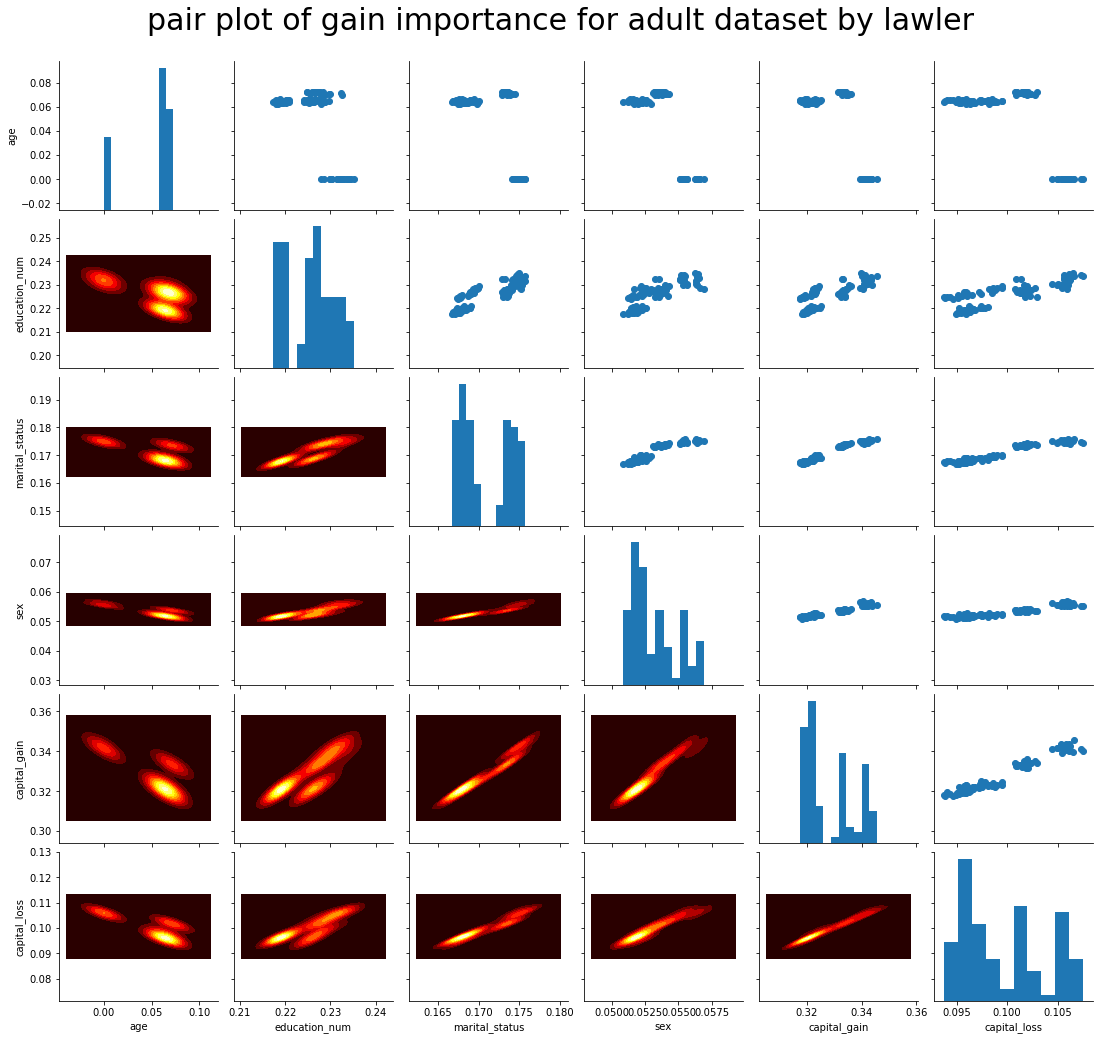

In [26]:
g = sns.pairplot(df)
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap='hot', shade=True)
g = g.map_diag(plt.hist)
plt.subplots_adjust(top=0.9)
g = g.fig.suptitle("pair plot of gain importance for adult dataset by lawler",
                      y=0.95, size=30)

In [22]:
df = pd.DataFrame(per)
df = df[[0, 1, 2, 4, 5 , 6]]
feature = data.columns
print(feature[[0, 1, 2, 4, 5 , 6]])
df.columns = feature[[0, 1, 2, 4, 5 , 6]]
df.head()

Index(['age', 'education_num', 'marital_status', 'sex', 'capital_gain',
       'capital_loss'],
      dtype='object')


,age,education_num,marital_status,sex,capital_gain,capital_loss
0,0.109338,0.178546,0.127441,0.087896,0.232073,0.083405
1,0.000000,0.167871,0.158758,0.089787,0.277289,0.098285
2,0.000000,0.226424,0.152618,0.084446,0.272645,0.100221
3,0.109661,0.216845,0.123376,0.077981,0.246813,0.088796
4,0.107093,0.181921,0.128806,0.089120,0.236075,0.085870


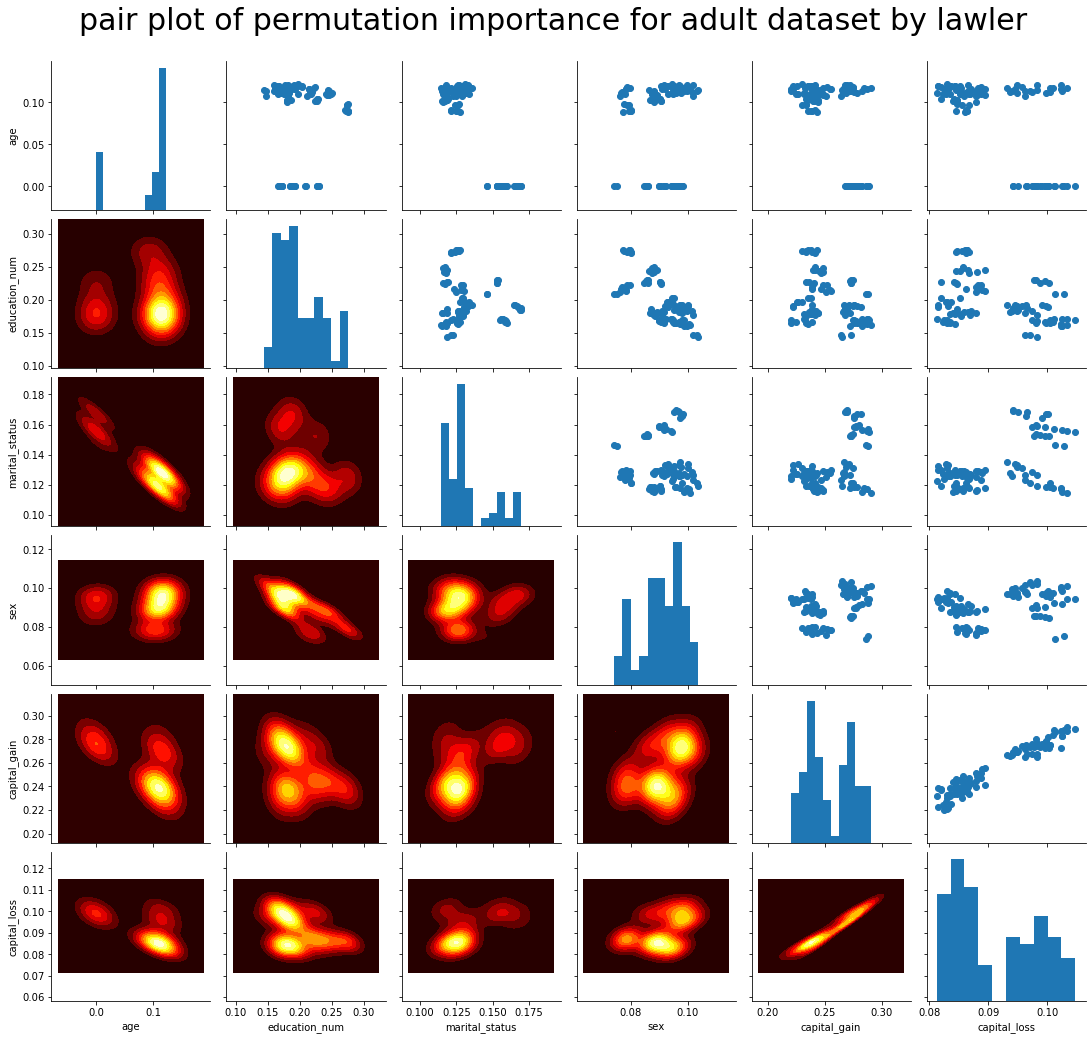

In [24]:
g = sns.pairplot(df)
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap='hot', shade=True)
g = g.map_diag(plt.hist)
plt.subplots_adjust(top=0.9)
g = g.fig.suptitle("pair plot of permutation importance for adult dataset by lawler",
                      y=0.95, size=30)